# Peter's Code

In [1]:
from ugali.analysis.isochrone import factory as isochrone_factory
from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import numpy as np
import fitsio

def mkpol(mu, age=12., z=0.0004, dmu=0.5, C=[0.05, 0.05], E=4., err=None, survey='DECaLS', clip=None):
    if err == None:
        print('Using DES err!')
        err = surveys.surveys['DES_DR1']['err']
    """ Builds ordered polygon for masking """

    iso = isochrone_factory('Bressan2012', survey='des',
                            age=age, distance_modulus=mu, z=z)
    c = iso.color
    m = iso.mag

    clip=4
    if clip is not None:
        # Clip for plotting, use gmin otherwise
        # clip abs mag
        cut = (m > clip) & ((m + mu) < 24) & (c > 0) & (c < 1)
        c = c[cut]
        m = m[cut]

    mnear = m + mu - dmu / 2.
    mfar = m + mu + dmu / 2.
    C = np.r_[c + E * err(mfar) + C[1], c[::-1] -  E * err(mnear[::-1]) - C[0]]
    M = np.r_[m, m[::-1]]
    return np.c_[C, M],iso
err=lambda x: (0.0010908679647672335 + np.exp((x - 27.091072029215375) / 1.0904624484538419))

def feh2z( feh):
        # Section 3 of Dotter et al. 2008
        Y_p     = 0.245            # Primordial He abundance (WMAP, 2003)
        c       = 1.54             # He enrichment ratio 

        # This is not well defined...
        #Z_solar/X_solar = 0.0229  # Solar metal fraction (Grevesse 1998)
        ZX_solar = 0.0229
        return (1 - Y_p)/( (1 + c) + (1/ZX_solar) * 10**(-feh))
    
def dist_fu(ra):
    # given ra in deg return distance of 300s in kpc from fu et al.  
    return 48.9952-0.2083*ra

def dist2mod(dist):
    return np.log10(dist*1e3)*5-5

In [2]:
# rough isochrone for 300s
mu = 16.1
age=13.5
feh=-1.26
z=feh2z(feh)
mk,iso=mkpol(mu,age,z,dmu=0.5,C=[0.05,0.05],E=4,err=err, survey="DES_Y3A2", clip=0.3)
pth=Path(mk)

In [3]:
detBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
data = fitsio.read(detBalrStarFile)
GMAG = data['true_g_Corr']
GR = data['true_gr_Corr']
RA = data['true_ra']
DIST = dist_fu(RA)
MU = dist2mod(DIST)
MG = GMAG - MU

/tmp/ipykernel_1227954/1359516253.py:50: RuntimeWarning: invalid value encountered in log10
  return np.log10(dist*1e3)*5-5


In [4]:
filtsel=Path.contains_points(pth,np.vstack((GR,MG)).T)
filtcat=data[filtsel]

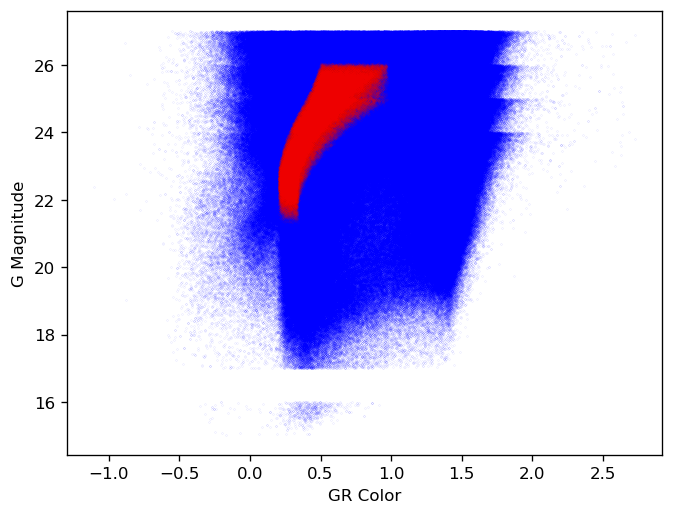

In [5]:
plt.figure(dpi = 120)
plt.scatter(GR[~filtsel], GMAG[~filtsel], color = 'b', s = 0.001)
plt.scatter(GR[filtsel], GMAG[filtsel], color = 'red', s = 0.001)
plt.xlabel('GR Color')
plt.ylabel('G Magnitude')
plt.show()

# Mitch's Code

## Parameters From Mitch's Simple Search

isochrone: # Here you can set the age and metallicity of the stellar population you're trying to detect

  age: 12
  
  metallicity: 0.0001
  
  name: Bressan2012
  
  survey: des

In [6]:
import fitsio
import numpy as np
import yaml
import simple.survey

In [7]:
# Read config file and set up "survey" object
with open('/afs/hep.wisc.edu/home/kkboone/software/simple/config.yaml') as fname:
    config = yaml.safe_load(fname)
    survey = simple.survey.Survey(config)

# Create isochrone
iso = survey.get_isochrone(distance_modulus=18.5) # Change modulus to whatever you want
    # This will load the age, metalliticy, and isochone type (i.e. Bressan2012) from the config file

Reading fracdet map /hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz ...
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = EXPLICIT
Ordering converted to RING


In [8]:
detBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
data = fitsio.read(detBalrStarFile)
mag_g = data['true_g_Corr']
mag_r = mag_g - data['true_gr_Corr']

mag_g_err = np.zeros_like(mag_g)
mag_r_err = np.zeros_like(mag_r)

gr_color = mag_g - mag_r

In [9]:
cut = iso.cut_separation('g', 'r', mag_g, mag_r, mag_g_err, mag_r_err, radius=0.1)

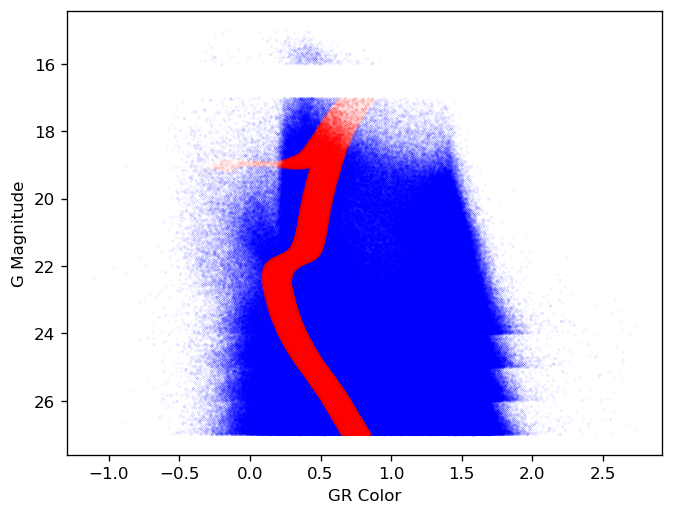

In [10]:
plt.figure(dpi = 120)
plt.scatter(gr_color[~cut], mag_g[~cut], color = 'b', s = 0.001)
plt.scatter(gr_color[cut], mag_g[cut], color = 'red', s = 0.001)
plt.xlabel('GR Color')
plt.ylabel('G Magnitude')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [11]:
np.sum(cut)

278915

In [12]:
matBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_matched_catalog_sof_run2_stars_v1.4.fits'
data = fitsio.read(matBalrStarFile, columns = ['meas_psf_mag'])

mag_g = data['meas_psf_mag'][:,0]
mag_r = data['meas_psf_mag'][:,1]

magCut = np.where((mag_g > 0) & (mag_g < 37) & (mag_r > 0) & (mag_r < 37))[0]

mag_g = mag_g[magCut]
mag_r = mag_r[magCut]

mag_g_err = np.zeros_like(mag_g)
mag_r_err = np.zeros_like(mag_r)

gr_color = mag_g - mag_r

In [19]:
cut = iso.cut_separation('g', 'r', mag_g, mag_r, mag_g_err, mag_r_err)#, radius=0.1)

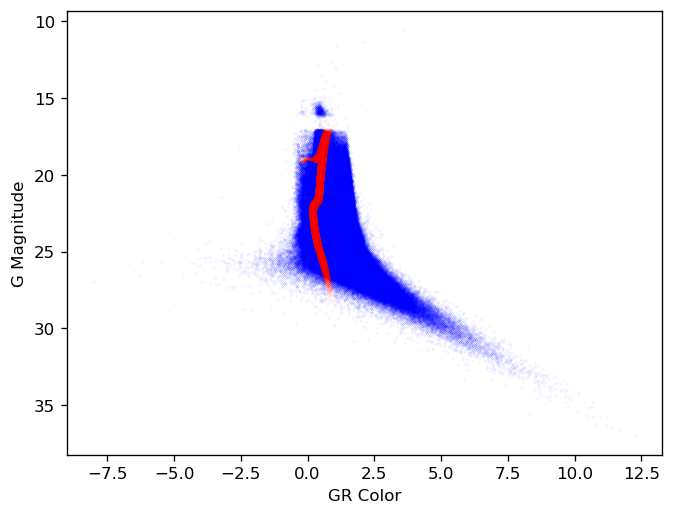

In [20]:
plt.figure(dpi = 120)
plt.scatter(gr_color[~cut], mag_g[~cut], color = 'b', s = 0.001)
plt.scatter(gr_color[cut], mag_g[cut], color = 'red', s = 0.001)
plt.xlabel('GR Color')
plt.ylabel('G Magnitude')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [21]:
cutMag = mag_r[cut]
cutColor = gr_color[cut]

sortInds = cutMag.argsort()
cutMag = cutMag[sortInds[::1]]
cutColor = cutColor[sortInds[::1]]

In [22]:
splitMags = np.array_split(cutMag, 5)
splitColors = np.array_split(cutColor, 5)

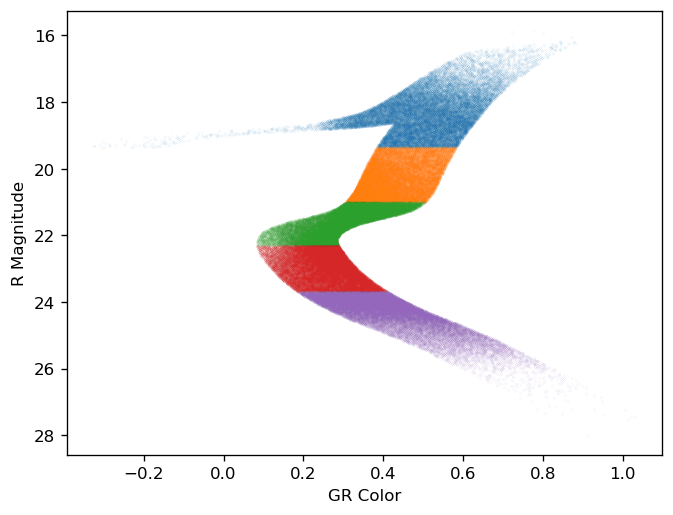

In [23]:
plt.figure(dpi = 120)
for i in range(len(splitMags)):
    plt.scatter(splitColors[i], splitMags[i], s = 0.001)
plt.xlabel('GR Color')
plt.ylabel('R Magnitude')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [24]:
for i in range(len(splitMags)):
    print(len(splitMags[i]))

34981
34981
34981
34981
34980
